In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# google drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install konlpy
!pip install pydub librosa numpy
!pip install openai-whisper
!pip install tqdm
!pip install jamo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 73.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.5/800.5 kB 10.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.4/209.4 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 44.8 MB/s eta 0:00:00
  Created wheel for openai-whisper: filename=openai_whisper-20240930-py3-none-any.whl size=803321 sha256=6e70ff7e1310f5dd7989a5c68eb08369270e077a12340a72f2557bd9d5640108
  Stored in directory: /root/.cache/pip/wheels/dd/4a/1f/d1c4bf3b9133c8168fe617ed979cab7b14fe381d059ffb9d83
Successfully built openai-whisper


In [ ]:
import os
import re
import glob
import torch
import librosa
import numpy as np
import torchaudio
import matplotlib.pyplot as plt
from konlpy.tag import Okt
from collections import Counter
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from transformers import WhisperForConditionalGeneration


In [ ]:
def check_matching_names(audio_dir, label_dir, audio_ext='.wav', label_ext='.txt'):
    """
    두 폴더(audio_dir, label_dir)의 파일 이름이 일치하는지 검사하는 함수.
    확장자를 제외한 파일명이 일치해야 함.

    Parameters:
    - audio_dir: 오디오 파일이 위치한 디렉토리 경로
    - label_dir: 라벨 파일이 위치한 디렉토리 경로
    - audio_ext: 오디오 파일의 확장자 (기본값: .wav)
    - label_ext: 라벨 파일의 확장자 (기본값: .txt)

    Returns:
    - True: 모든 파일명이 일치하는 경우
    - False: 일치하지 않는 파일명을 출력하고, False 반환
    """
    # 오디오 파일과 라벨 파일 목록 가져오기 (확장자를 제외한 파일명 추출)
    audio_files = {os.path.splitext(f)[0] for f in os.listdir(audio_dir) if f.endswith(audio_ext)}
    label_files = {os.path.splitext(f)[0] for f in os.listdir(label_dir) if f.endswith(label_ext)}

    # 오디오 파일과 라벨 파일의 이름 비교
    missing_in_labels = audio_files - label_files  # 라벨 폴더에 없는 오디오 파일
    missing_in_audio = label_files - audio_files   # 오디오 폴더에 없는 라벨 파일

    if not missing_in_labels and not missing_in_audio:
        print("All filenames match between audio and label folders.")
        return True
    else:
        if missing_in_labels:
            print(f"These audio files are missing in the label folder: {sorted(missing_in_labels)}")
        if missing_in_audio:
            print(f"These label files are missing in the audio folder: {sorted(missing_in_audio)}")
        return False

audio_dir = "/content/drive/MyDrive/dataset/audio"
label_dir = "/content/drive/MyDrive/dataset/label"

if check_matching_names(audio_dir, label_dir):
    print("All audio and label files are properly matched.")
else:
    print("Some files are mismatched between audio and label directories.")

All filenames match between audio and label folders.
All audio and label files are properly matched.


# 데이터 준비

## 음성파일 자르고 라벨 데이터 만들기

In [ ]:
# '''
# 휴리스틱 기반으로 무음구간 제거
# 최대 길이 29초
# '''

# from pydub import AudioSegment
# from pydub.silence import detect_silence
# # 음성파일 길이 29 이하로 자르기
# '''
# 파라미터 조정

# audio2 1000, -10  적절히 분할 됨 not bad
# audio6 1000, -25  밑으로는 너무 많이 분할됨
# audio3 1000, -40  너무 많이 분할됨
# '''
# # 경로 설정
# audio_dir = "/content/drive/MyDrive/dataset/audio"
# output_audio_dir = "/content/drive/MyDrive/dataset/split_audio7"
# os.makedirs(output_audio_dir, exist_ok=True)

# # DFS 알고리즘
# def split_audio(audio, audio_filename, count=0, duration_thresh=29000, initial_silence_len=1000, silence_thresh=-15):
#     duration = len(audio)  # 전체 길이 (밀리초 단위)

#     while initial_silence_len > 0:
#         silences = detect_silence(audio, min_silence_len=initial_silence_len, silence_thresh=silence_thresh)

#         if silences:
#             # 분할 수행
#             split_points = [0] + [(start + end) / 2 for start, end in silences] + [duration]

#             for i in range(len(split_points) - 1):
#                 start_time = split_points[i]
#                 end_time = split_points[i + 1]
#                 segment_duration = end_time - start_time

#                 if segment_duration < duration_thresh:  # 29초 미만이면 저장
#                     save_splited(audio[start_time:end_time], audio_filename, count)
#                     count += 1
#                 else:  # 29초 이상
#                     # 재귀 호출 시 count를 넘겨줌
#                     audio_segment = audio[start_time:end_time]
#                     count = split_audio(audio_segment, audio_filename, count, duration_thresh, initial_silence_len - 100, silence_thresh)

#             return count  # count 값을 반환하여 다음 호출에서도 유지되게 함

#         # 침묵이 없으면 침묵 길이 줄이기
#         initial_silence_len = initial_silence_len - 100

#     return count  # 모든 분할이 끝난 후 count 반환


# # 오디오 파일 저장 함수
# def save_splited(audio, audio_filename, count):
#     basename = os.path.splitext(os.path.basename(audio_filename))[0]
#     split_audio_path = os.path.join(output_audio_dir, f"{basename}_split_{count}.wav")
#     audio.export(split_audio_path, format="wav")
#     print(f"Saved split audio: {split_audio_path}")

# # 모든 오디오 파일에 대해 분할 수행
# for audio_filename in os.listdir(audio_dir):
#     # if audio_filename != 'ID-02-25-N-KSM-06-02-M-45-JL.wav': # count 문제가 있었던 파일
#     #     continue
#     if audio_filename.endswith(('.wav', '.mp3', '.flac', '.ogg')):
#         audio_path = os.path.join(audio_dir, audio_filename)
#         duration = librosa.get_duration(path=audio_path)  # 'filename' 파라미터를 'path'로 수정
#         if duration > 29: # 초 단위
#             print(f"Processing {audio_filename} with duration {duration} seconds.")
#             audio = AudioSegment.from_file(audio_path)  # 오디오를 읽어오기
#             split_audio(audio, audio_filename, count=0)
#         else:
#             print(f"Skipping {audio_filename} with duration {duration} seconds.")


Processing ID-02-26-N-BDI-03-F-51-KK.wav with duration 176.19995464852607 seconds.
Saved split audio: /content/drive/MyDrive/dataset/split_audio7/ID-02-26-N-BDI-03-F-51-KK_split_0.wav
Saved split audio: /content/drive/MyDrive/dataset/split_audio7/ID-02-26-N-BDI-03-F-51-KK_split_1.wav
Saved split audio: /content/drive/MyDrive/dataset/split_audio7/ID-02-26-N-BDI-03-F-51-KK_split_2.wav
Saved split audio: /content/drive/MyDrive/dataset/split_audio7/ID-02-26-N-BDI-03-F-51-KK_split_3.wav
Saved split audio: /content/drive/MyDrive/dataset/split_audio7/ID-02-26-N-BDI-03-F-51-KK_split_4.wav
Saved split audio: /content/drive/MyDrive/dataset/split_audio7/ID-02-26-N-BDI-03-F-51-KK_split_5.wav
Saved split audio: /content/drive/MyDrive/dataset/split_audio7/ID-02-26-N-BDI-03-F-51-KK_split_6.wav
Saved split audio: /content/drive/MyDrive/dataset/split_audio7/ID-02-26-N-BDI-03-F-51-KK_split_7.wav
Processing ID-02-26-N-BDS-01-02-M-25-KK.wav with duration 140.98 seconds.
Saved split audio: /content/drive/M

KeyboardInterrupt: 

In [ ]:
# model = whisper.load_model("large")  # "base", "small", "medium", "large" 중 선택

100%|█████████████████████████████████████| 2.88G/2.88G [00:35<00:00, 87.0MiB/s]
/usr/local/lib/python3.10/dist-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exper

In [ ]:
# STT 함수
def perform_stt(audio_split_path):
    result = model.transcribe(audio_split_path, word_timestamps=True, language="ko")
    # print(result)
    torch.cuda.empty_cache()  # 메모리 캐시 해제
    return result['text']

In [ ]:
# # 경로
# label_dir = '/content/drive/MyDrive/dataset/label'
# # split_audio_dir = '/content/drive/MyDrive/Colab Notebooks/sampledata/split_audio2'
# split_label_dir = '/content/drive/MyDrive/Colab Notebooks/sampledata/split_label3'

# # 저장할 경로 생성
# os.makedirs(split_label_dir, exist_ok=True)


In [ ]:
# import os
# import torch

# # STT한 라벨 텍스트 저장하기

# # 전체 라벨 데이터를 처리
# for label_filename in os.listdir(label_dir):
#     label_path = os.path.join(label_dir, label_filename)

#     # 라벨 파일 읽기
#     with open(label_path, 'r', encoding='utf-8') as label_file:
#         label_text = label_file.read()

#     # 오디오 파일들에 대해 처리
#     for i in range(len(os.listdir(split_audio_dir))):
#         audio_split_path = os.path.join(split_audio_dir, f'{label_filename[:-4]}_split_{i}.wav')

#         # 파일이 존재하는지 확인
#         if not os.path.exists(audio_split_path):
#             break

#         # STT 결과 가져오기
#         stt_result = perform_stt(audio_split_path)
#         stt_result = re.sub(r'^[^가-힣]+|[^가-힣.,?!\s]', '', stt_result)

#         # 결과를 split_lavel_dir에 저장
#         output_path = os.path.join(split_lavel_dir, f'{label_filename[:-4]}_split_{i}.txt')
#         with open(output_path, 'w', encoding='utf-8') as out_file:
#             out_file.write(stt_result)


In [ ]:
# 자카드 유사도 계산 함수 , Cosine Similarity, Levenshtein Distance 방법도 있음
from jamo import h2j, j2hcj

# 자음 모음 분해해서 계산
def jaccard_similarity_jamo(s1, s2):
    s1_set = set(''.join(j2hcj(h2j(s1)))) # 한글을 자음 모음 분해
    s2_set = set(''.join(j2hcj(h2j(s2))))
    intersection = s1_set.intersection(s2_set)
    union = s1_set.union(s2_set)
    return len(intersection) / (len(union) + 0.001)


# def jaccard_similarity(s1, s2):
#     s1_set = set(s1)
#     s2_set = set(s2)
#     intersection = s1_set.intersection(s2_set)
#     union = s1_set.union(s2_set)
#     return len(intersection) / (len(union) + 0.001)

# 자카드 유사도 계산 함수 (토큰화된 텍스트 사용)
def jaccard_similarity(set1, set2):
    set1, set2 = set(set1), set(set2)
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union if union != 0 else 0

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity as sklearn_cosine_similarity

def calculate_cosine_similarity(text1, text2):
    # TF-IDF 벡터화
    vectorizer = TfidfVectorizer().fit_transform([text1, text2])
    vectors = vectorizer.toarray()

    # 코사인 유사도 계산
    cos_sim = sklearn_cosine_similarity(vectors)

    # 첫 번째 텍스트와 두 번째 텍스트 간의 유사도 값 반환
    return cos_sim[0][1]

In [ ]:
# 예시
text1 = "나는"
text2 = "내가"
text3 = "자금"

print(f"코사인 유사도: {calculate_cosine_similarity(text1, text3)}")
print(f"자카드 유사도: {jaccard_similarity(text1, text3)}")
print(f"자카드 유사도2: {jaccard_similarity_jamo(text1, text3)}")

코사인 유사도: 0.0
자카드 유사도: 0.0
자카드 유사도2: 0.33327778703549404


In [ ]:
# import os
# import torch
# # 경로
# label_dir = '/content/drive/MyDrive/dataset/label'
# # split_audio_dir = '/content/drive/MyDrive/Colab Notebooks/sampledata/split_audio2'
# split_lavel_dir = '/content/drive/MyDrive/Colab Notebooks/sampledata/split_label2'

# # 전체 라벨 데이터를 처리
# for label_filename in os.listdir(label_dir):
#     label_path = os.path.join(label_dir, label_filename)

#     # 진짜 라벨 텍스트 읽기
#     with open(label_path, 'r', encoding='utf-8') as label_file:
#         label_text = label_file.read()

#     # STT한 라벨 텍스트 불러오기 및 비교
#     for i in range(len(os.listdir(split_lavel_dir))):
#         label_split_path = os.path.join(split_lavel_dir, f'{label_filename[:-4]}_split_{i}.txt')

#         # STT 라벨 파일이 존재하는지 확인
#         if not os.path.exists(label_split_path):
#             break

#         # STT 라벨 텍스트 읽기
#         with open(label_split_path, 'r', encoding='utf-8') as stt_file:
#             label_fake = stt_file.read()

#             # 한글, 공백, ., ?, !, , 만 남기고 나머지 제거
#             label_fake = re.sub(r'^[^가-힣]+|[^가-힣.,?!\s]', '', label_fake)

#         # 길이에 따른 분할 기준 설정
#         if len(label_fake) <= 8:
#             fake_start = label_fake[:4]
#             fake_end = label_fake[-4:]
#         else:
#             fake_start = label_fake[:9]
#             fake_end = label_fake[-9:]

#         # 각 분할 지점에서의 유사도 리스트 저장
#         similarity_list = []

#         # 진짜 라벨 텍스트의 시작 부분을 찾음
#         for start_idx in range(len(label_text) - len(fake_start) + 1):
#             sub_start = label_text[start_idx:start_idx + len(fake_start)]
#             start_sim = jaccard_similarity(fake_start, sub_start) #+ jaccard_similarity_jamo(fake_start, sub_start)/2 # 오래걸림

#             # 끝 부분에 대한 유사도
#             for end_idx in range(start_idx + len(fake_start), len(label_text) - len(fake_end) + 1):
#                 sub_end = label_text[end_idx:end_idx + len(fake_end)]
#                 end_sim = jaccard_similarity(fake_end, sub_end) #+ jaccard_similarity_jamo(fake_start, sub_start)/2

#                 # 유사도 저장: [시작 위치, 끝 위치, 시작 유사도, 끝 유사도]
#                 similarity_list.append([start_idx, end_idx + len(fake_end), start_sim, end_sim])

#         # similarity_list가 비어있는지 확인
#         if similarity_list:
#             # 시작 유사도와 끝 유사도를 비교하여 최적의 분할 지점을 찾음
#             best_split = max(similarity_list, key=lambda x: (x[2] + x[3]) / 2)  # 평균 유사도 기준

#             # 최종적으로 분할된 지점의 라벨 텍스트 추출
#             best_start_idx = best_split[0]
#             best_end_idx = best_split[1]
#             matched_text = label_text[best_start_idx:best_end_idx]
#             matched_text = re.sub(r'^[^가-힣]+|[^가-힣.,?!\s]', '', matched_text)

#             # 최종 분할 텍스트를 STT 파일에 덮어쓰기
#             # with open(label_split_path, 'w', encoding='utf-8') as stt_file:
#             #     stt_file.write(matched_text)

#             # 결과 출력
#             print(f"STT  결과: {label_fake}")
#             print(f"매칭 결과: {matched_text}")
#         else:
#             print(f"STT 결과: {label_fake}")
#             print("매칭할 수 있는 라벨 텍스트를 찾지 못했습니다.")


STT  결과: 제 나이는 살입니다. 저는 뱀띠입니다. 제가 태어난 곳은 남원군이고 주로 산 곳은 고양시입니다. 출생 지인은 남원시이고 열. 제가..
매칭 결과: 제 나이는 오십 십칠살입니다. 저는  뱀띠입니다 제가 태어난 곳은 남원군이고 주로 산 곳은  고양시입니다. 출생지는 남원시이고 열일곱살까지 살았습니다. 아버지는 전라도지역 출신이시고 어머니는 전라도 출신이십니다 제 위로는 오빠 둘 언니 한명이 아래로 여동생 한명이 있습니다. 우리 가족은 남편 딸 아들 그리고 저이고 그래서 모두 네명입니다. 지금 저랑 같이 살고 있는 사람은 남편과 딸입니다 가족과 주로 하는 이야기는 건강에 대한 것입니다. 친구와 주로 하는 이야기는 남편에 대한 것입니다. 저는 평소에 주로  자가용을 타고 다닙니다.  우리 동네는 교통이 불편 합니다. 교통이 불편한 이유는 차가 자주 오지 않기 때문입니다.  우리 집에서 서울역에 가려면 전철을 타고 가야 합니다. 우리 집 근처에는 홈플러스가 있는데 걸어서 오분 거리에 있습니다.  나는 보통 아침  일곱시에 일어나고 밤 열한시에 잡니다. 제가 가장 
STT  결과: 일곱 살까지 살았습니다. 아버지는 전라도 출신이고 어머니도 전라도 출신이십니다. 제 호는 오빠 둘 언니 한 명이 있고 아래로 여동생 한 명이 있습니다. 제 호는 아빠 둘이 한 명이 있고 아래로 여동생 한 명이 있습니다.
매칭 결과: 열일곱살까지 살았습니다. 아버지는 전라도지역 출신이시고 어머니는 전라도 출신이십니다 제 위로는 오빠 둘 언니 한명이 아래로 여동생 한명이 있습니다. 
STT  결과: 우리 가족은 남편, 딸, 아들 그리고 저이고 그래서 모두 명입니다. 지금 저랑 같이 살고 있는 사람은 남편과 딸입니다. 가족과 주로 하는 이야기는
매칭 결과: 우리 가족은 남편 딸 아들 그리고 저이고 그래서 모두 네명입니다. 지금 저랑 같이 살고 있는 사람은 남편과 딸입니다 가족과 주로 하는 이야기는
STT  결과: 건강에 대한 것입니다. 친구와 주로 하는 이야기는 남편에 대한 것입니다

KeyboardInterrupt: 

In [ ]:
# import os
# import torch

# okt = Okt()

# # 경로
# label_dir = '/content/drive/MyDrive/public/99_backup/label'
# # split_audio_dir = '/content/drive/MyDrive/Colab Notebooks/sampledata/split_audio2'
# split_label_dir = '/content/drive/MyDrive/Colab Notebooks/sampledata/split_label2'

# # 저장할 위치
# new_path = '/content/drive/MyDrive/Colab Notebooks/sampledata/split_label4'
# os.makedirs(new_path, exist_ok=True)


# # 전체 라벨 데이터를 처리
# for label_filename in os.listdir(label_dir):
#     label_path = os.path.join(label_dir, label_filename)

#     # 진짜 라벨 텍스트 읽기
#     with open(label_path, 'r', encoding='utf-8') as label_file:
#         label_text = label_file.read()

#     label_text = re.sub(r'^[^가-힣]+|[^가-힣.,?!\s]', '', label_text)
#     # label_text 토큰화
#     label_text = okt.morphs(label_text)

#     # STT한 라벨 텍스트 불러오기 및 비교
#     for i in range(len(os.listdir(split_label_dir))):
#         label_split_path = os.path.join(split_label_dir, f'{label_filename[:-4]}_split_{i}.txt')

#         # STT 라벨 파일이 존재하는지 확인
#         if not os.path.exists(label_split_path):
#             break

#         # STT 라벨 텍스트 읽기
#         with open(label_split_path, 'r', encoding='utf-8') as stt_file:
#             label_fake = stt_file.read()

#             # 한글, 공백, ., ?, !, , 만 남기고 나머지 제거
#             label_fake = re.sub(r'^[^가-힣]+|[^가-힣.,?!\s]', '', label_fake)
#             tokenized_label = okt.morphs(label_fake)
#             new = []
#             # 비교해서 가장 잘 맞는 단어로 체인지하기
#             for i in range(len(tokenized_label)):
#                 tmp = []
#                 for ans in label_text:
#                     sim = jaccard_similarity(tokenized_label[i], ans) + jaccard_similarity_jamo(tokenized_label[i], ans)/2
#                     tmp.append((sim, ans))

#                 # 값이 최고인 인덱스를 찾아서 바꿔주기
#                 if tmp:  # tmp가 비어 있지 않다면
#                     best_match = max(tmp, key=lambda x: x[0])  # 최대 유사도를 가진 요소
#                     new.append(best_match[1])  # 가장 유사한 단어를 추가

#             # new 는 이제 라벨데이터의 토큰을 가지고 있으나 빠진 단어가 있다.
#             # 라벨 데이터와 비교해서 빠진 단어를 채워넣어주자
#             #

#             # print(f"{label_fake}")
#             # print(' '.join(new))


#             new_split_path = os.path.join(new_path, os.path.basename(label_split_path))
#             with open(new_split_path, 'w', encoding='utf-8') as new_file:
#                 new_file.write(' '.join(new))





In [ ]:
# 분할해서 새로 만든 라벨과 음성파일의 이름이 일치하는지 검사

def check_matching_names(audio_dir, label_dir, audio_ext='.wav', label_ext='.txt'):
    """
    두 폴더(audio_dir, label_dir)의 파일 이름이 일치하는지 검사하는 함수.
    확장자를 제외한 파일명이 일치해야 함.

    Parameters:
    - audio_dir: 오디오 파일이 위치한 디렉토리 경로
    - label_dir: 라벨 파일이 위치한 디렉토리 경로
    - audio_ext: 오디오 파일의 확장자 (기본값: .wav)
    - label_ext: 라벨 파일의 확장자 (기본값: .txt)

    Returns:
    - True: 모든 파일명이 일치하는 경우
    - False: 일치하지 않는 파일명을 출력하고, False 반환
    """
    # 오디오 파일과 라벨 파일 목록 가져오기 (확장자를 제외한 파일명 추출)
    audio_files = {os.path.splitext(f)[0] for f in os.listdir(audio_dir) if f.endswith(audio_ext)}
    label_files = {os.path.splitext(f)[0] for f in os.listdir(label_dir) if f.endswith(label_ext)}

    # 오디오 파일과 라벨 파일의 이름 비교
    missing_in_labels = audio_files - label_files  # 라벨 폴더에 없는 오디오 파일
    missing_in_audio = label_files - audio_files   # 오디오 폴더에 없는 라벨 파일

    if not missing_in_labels and not missing_in_audio:
        print("All filenames match between audio and label folders.")
        return True
    else:
        if missing_in_labels:
            print(f"These audio files are missing in the label folder: {sorted(missing_in_labels)}")
        if missing_in_audio:
            print(f"These label files are missing in the audio folder: {sorted(missing_in_audio)}")
        return False

# split_audio_dir = "/content/drive/MyDrive/dataset/Split dataset(여기다가 추가!)/audio"
# split_label_dir = "/content/drive/MyDrive/dataset/Split dataset(여기다가 추가!)/label"

split_audio_dir = "/content/drive/MyDrive/Colab Notebooks/sampledata/split_audio2"
split_label_dir = "/content/drive/MyDrive/Colab Notebooks/sampledata/split_label4"


if check_matching_names(split_audio_dir, split_label_dir):
    print("All audio and label files are properly matched.")
else:
    print("Some files are mismatched between audio and label directories.")

All filenames match between audio and label folders.
All audio and label files are properly matched.


In [ ]:
# okt = Okt()
# word_list = []

# # 모든 .txt 파일 경로 가져오기
# label_dir = '/content/drive/MyDrive/public/99_backup/label'
# txt_files = glob.glob(os.path.join(label_dir, "*.txt"))

# for txt_file in txt_files:
#     try:
#         with open(txt_file, 'r', encoding='utf-8') as f:
#             text = f.read().strip()
#         text = re.sub(r"[^가-힣\s]", "", text)
#         # 토크나이징
#         tokenized = okt.morphs(text)
#         word_list.extend(tokenized)
#     except Exception as e:
#         print(f"Error processing file {txt_file}: {e}")

# # 각 단어별 등장 빈도를 계산하여 등장 빈도가 높은 순서로 정렬
# # Counter는 단어를 키(key), 등장 빈도를 값(value)으로 가지도록 반환
# word_counts = Counter(word_list)
# word_counts = sorted(word_counts, key=word_counts.get, reverse=True)


# Whisper 토크나이저는 자체 패딩 토큰을 사용하므로, 별도의 사전 정의 필요 없음
# 필요한 경우, 토크나이저 설정 조정 가능
# tokenizer.pad_token = "<PAD>"  # 기본적으로 Whisper 토크나이저는 pad_token을 정의하지 않음
# word_to_index = {}
# word_to_index['<PAD>'] = 0
# word_to_index['<UNK>'] = 1
# word_to_index['<BLANK>'] = 2

# 등장 빈도가 높은 단어일수록 낮은 정수를 부여
# for index, word in enumerate(word_counts):
#     if word not in ['<PAD>', '<UNK>', '<BLANK>']:
#         word_to_index[word] = index + 3

# # `<UNK>`의 인덱스를 미리 저장
# UNK_IDX = word_to_index['<UNK>']


In [ ]:
# print("단어집합 크기 :", len(word_to_index))

단어집합 크기 : 1427


# 위스퍼 데이터셋 만들기

In [ ]:
from transformers import WhisperTokenizer

tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-base")
# vocab = tokenizer.get_vocab()

In [ ]:
# def encode_text(text, tokenizer):
#     return tokenizer.encode(text, add_special_tokens=False)

# def decode_tokens(tokens, tokenizer):
#     return tokenizer.decode(tokens, skip_special_tokens=True)

In [ ]:

# def load_audio(file_path, sr=16000):
#     audio, _ = librosa.load(file_path, sr=sr)
#     return audio

# def normalize_audio(audio):
#     return audio / max(abs(audio))

# def audio_to_log_mel(audio, sr=16000, n_mels=80):
#     spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)
#     log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
#     return log_spectrogram


In [ ]:
def collate_fn(batch):
    """
    배치 내의 시퀀스 길이가 다를 경우 패딩을 추가하는 함수.
    """
    log_mels, encoded_texts = zip(*batch)

    # log-Mel 스펙트로그램 패딩 (길이 기준)
    max_mel_length = max(mel.shape[1] for mel in log_mels)
    padded_mels = torch.zeros(len(log_mels), log_mels[0].shape[0], max_mel_length)
    for i, mel in enumerate(log_mels):
        padded_mels[i, :, :mel.shape[1]] = mel

    # 텍스트 인코딩 패딩 (길이 기준)
    max_text_length = max(len(text) for text in encoded_texts)
    padded_texts = torch.full((len(encoded_texts), max_text_length), fill_value=tokenizer.pad_token_id, dtype=torch.long)
    for i, text in enumerate(encoded_texts):
        padded_texts[i, :len(text)] = text

    return padded_mels, padded_texts


In [ ]:
class WhisperDataset(Dataset):
    def __init__(self, audio_dir, label_dir, tokenizer, sr=16000, n_mels=80):
        self.audio_dir = audio_dir
        self.label_dir = label_dir
        self.tokenizer = tokenizer
        self.file_names = [f for f in os.listdir(audio_dir) if f.endswith('.wav')]
        self.sr = sr
        self.n_mels = n_mels

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        audio_path = os.path.join(self.audio_dir, self.file_names[idx])
        label_path = os.path.join(self.label_dir, self.file_names[idx].replace('.wav', '.txt'))

        # 오디오 처리
        audio, _ = librosa.load(audio_path, sr=self.sr)
        audio = audio / max(abs(audio)) if max(abs(audio)) != 0 else audio

        spectrogram = librosa.feature.melspectrogram(y=audio, sr=self.sr, n_mels=self.n_mels)
        log_mel = librosa.power_to_db(spectrogram, ref=np.max)
        log_mel = torch.tensor(log_mel, dtype=torch.float32)

        # 패딩 추가 또는 크기 조정
        target_size = 3000
        current_size = log_mel.size(1)

        if current_size < target_size:
            pad_width = target_size - current_size
            log_mel = torch.nn.functional.pad(log_mel, (0, pad_width), mode='constant', value=0)
        elif current_size > target_size:
            log_mel = log_mel[:, :target_size]

        # 텍스트 처리
        with open(label_path, 'r', encoding='utf-8') as f:
            text = f.read().strip()
        text = re.sub(r"[^가-힣\s]", "", text)

        # Whisper 토크나이저를 사용하여 텍스트 인코딩
        encoded = self.tokenizer.encode(text, add_special_tokens=False)
        encoded = torch.tensor(encoded, dtype=torch.long)

        return log_mel, encoded


In [ ]:
# # 배치사이즈 재조정할때 실행
# torch.cuda.empty_cache()

In [ ]:
# 경로
# split_audio_dir = "/content/drive/MyDrive/Colab Notebooks/sampledata/split_audio2"
# split_label_dir = "/content/drive/MyDrive/Colab Notebooks/sampledata/split_label4"

split_audio_dir = '/content/drive/MyDrive/public/dataset/audio'
split_label_dir = '/content/drive/MyDrive/public/dataset/label'

# 데이터셋 생성
dataset = WhisperDataset(audio_dir=split_audio_dir, label_dir=split_label_dir, tokenizer=tokenizer)

# 데이터셋 분할
dataset_size = len(dataset)
train_size = int(0.7 * dataset_size)  # 70% for training
val_size = int(0.15 * dataset_size)   # 15% for validation
test_size = dataset_size - train_size - val_size  # 15% for testing

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

# 데이터셋 크기 출력
print(f"Training set size: {train_size}")
print(f"Validation set size: {val_size}")
print(f"Test set size: {test_size}")



Training set size: 2937
Validation set size: 629
Test set size: 631


In [ ]:
test_dataset[0]

(tensor([[-77.5574, -71.9794, -70.7164,  ...,   0.0000,   0.0000,   0.0000],
         [-76.1761, -71.5580, -70.0144,  ...,   0.0000,   0.0000,   0.0000],
         [-72.8219, -68.4998, -71.3736,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [-80.0000, -80.0000, -80.0000,  ...,   0.0000,   0.0000,   0.0000],
         [-80.0000, -80.0000, -80.0000,  ...,   0.0000,   0.0000,   0.0000],
         [-80.0000, -80.0000, -80.0000,  ...,   0.0000,   0.0000,   0.0000]]),
 tensor([ 5786,   116, 28319]))

Encoded Text: tensor([18739, 39364])


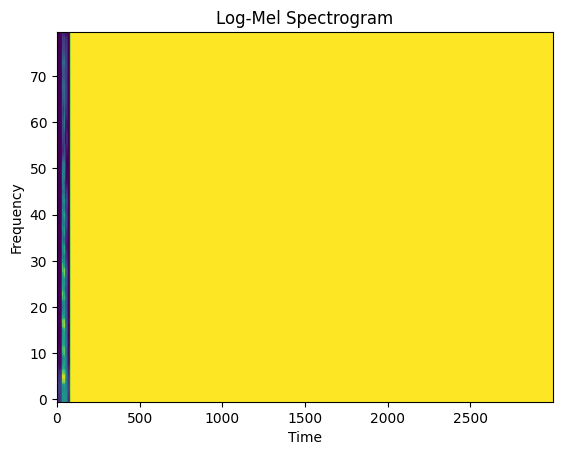

In [ ]:
# 첫 번째 샘플 확인
log_mel, encoded = dataset[0]
print("Encoded Text:", encoded)

# log-Mel 스펙트로그램 시각화
plt.imshow(log_mel, aspect='auto', origin='lower')
plt.title("Log-Mel Spectrogram")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()

In [ ]:
log_mel.shape

torch.Size([80, 3000])

# 모델 학습 및 평가

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np


In [ ]:
from transformers import WhisperForConditionalGeneration, WhisperTokenizer
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 및 토크나이저 설정
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-base")
model = model.to(device)


# 모델 가중치 로드 : 학습완료된 모델 불러올때
model.load_state_dict(torch.load('whisper_model.pth', map_location=device))

<ipython-input-18-3ce984bf3062>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('whisper_model.pth', map_location=device))


<All keys matched successfully>

In [ ]:
'''
손실 함수 및 옵티마이저 설정:

Whisper 모델은 자체적으로 labels를 입력받아 손실을 계산하므로,
별도의 손실 함수를 정의할 필요가 없습니다.
따라서 CrossEntropyLoss 대신 모델의 outputs.loss를 사용할 수 있습니다.
'''
# 손실 함수 및 옵티마이저 설정
optimizer = optim.AdamW(model.parameters(), lr=3e-5)

In [ ]:
# 모델 학습하기

num_epochs = 10  # 에폭 수 설정
patience = 2  # 얼리스타핑 기준 (2번 연속으로 개선되지 않으면 스탑)
best_val_loss = float('inf')  # 벨리데이션 로스를 기록할 변수 (초기값은 무한대)
patience_counter = 0  # 얼리스탑핑 카운터

# 손실 기록을 위한 리스트 초기화
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()  # 학습 모드로 전환
    epoch_loss = 0.0

    # Training loop
    for log_mel, encoded in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        log_mel = log_mel.to(device)
        encoded = encoded.to(device)

        optimizer.zero_grad()  # 기울기 초기화

        # 모델 예측 및 손실 계산
        outputs = model(input_features=log_mel, labels=encoded)
        loss = outputs.loss

        loss.backward()  # 기울기 계산
        optimizer.step()  # 가중치 업데이트

        epoch_loss += loss.item()  # 에폭 손실 합산

    # 에폭 손실 출력
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)  # 훈련 손실 기록
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}")

    # Validation step (검증 손실 계산)
    model.eval()  # 평가 모드로 전환
    val_loss = 0.0
    with torch.no_grad():  # 검증 단계에서는 기울기 계산 비활성화
        for log_mel, encoded in val_loader:
            log_mel = log_mel.to(device)
            encoded = encoded.to(device)

            outputs = model(input_features=log_mel, labels=encoded)
            loss = outputs.loss
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)  # 검증 손실 평균 계산
    val_losses.append(avg_val_loss)  # 검증 손실 기록

    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}")

    # Early stopping 조건 확인
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0  # 개선되었으므로 patience_counter 초기화
        # 모델 저장
        torch.save(model.state_dict(), 'best_whisper_model.pth')
    else:
        patience_counter += 1  # 개선되지 않았으므로 카운터 증가
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break  # 학습 중단


Epoch 1/10: 100%|██████████| 735/735 [08:39<00:00,  1.42it/s]


Epoch [1/10], Training Loss: 1.3269
Epoch [1/10], Validation Loss: 0.7919


Epoch 2/10: 100%|██████████| 735/735 [07:46<00:00,  1.58it/s]


Epoch [2/10], Training Loss: 0.6846
Epoch [2/10], Validation Loss: 0.6992


Epoch 3/10: 100%|██████████| 735/735 [07:51<00:00,  1.56it/s]


Epoch [3/10], Training Loss: 0.5847
Epoch [3/10], Validation Loss: 0.6476


Epoch 4/10: 100%|██████████| 735/735 [07:43<00:00,  1.59it/s]


Epoch [4/10], Training Loss: 0.4893
Epoch [4/10], Validation Loss: 0.5859


Epoch 5/10: 100%|██████████| 735/735 [07:53<00:00,  1.55it/s]


Epoch [5/10], Training Loss: 0.4103
Epoch [5/10], Validation Loss: 0.5470


Epoch 6/10: 100%|██████████| 735/735 [07:44<00:00,  1.58it/s]


Epoch [6/10], Training Loss: 0.3289
Epoch [6/10], Validation Loss: 0.5038


Epoch 7/10: 100%|██████████| 735/735 [07:51<00:00,  1.56it/s]


Epoch [7/10], Training Loss: 0.2383
Epoch [7/10], Validation Loss: 0.4600


Epoch 8/10: 100%|██████████| 735/735 [07:45<00:00,  1.58it/s]


Epoch [8/10], Training Loss: 0.1711
Epoch [8/10], Validation Loss: 0.4907


Epoch 9/10: 100%|██████████| 735/735 [07:46<00:00,  1.58it/s]


Epoch [9/10], Training Loss: 0.1434
Epoch [9/10], Validation Loss: 0.4176


Epoch 10/10: 100%|██████████| 735/735 [07:47<00:00,  1.57it/s]


Epoch [10/10], Training Loss: 0.0910
Epoch [10/10], Validation Loss: 0.4276


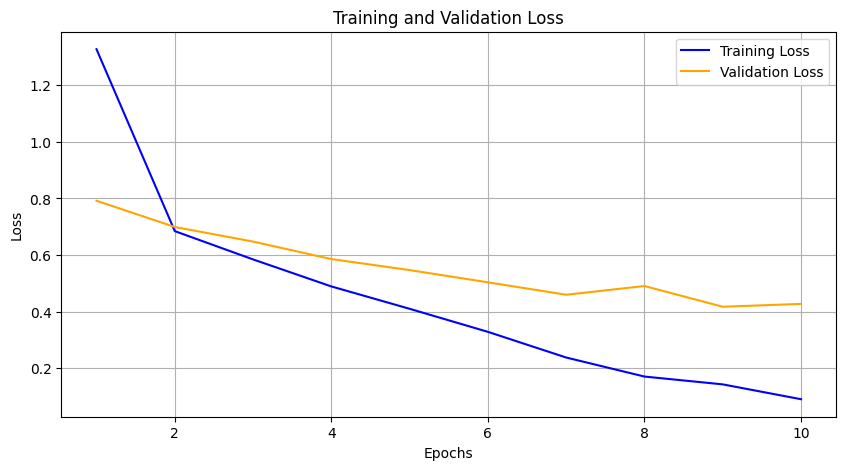

In [ ]:
# 훈련 검증 비교 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# 테스트 데이터셋으로 평가
model.eval()  # 평가 모드로 전환
with torch.no_grad():
    total_loss = 0.0
    for log_mel, encoded in test_loader:
        log_mel = log_mel.to(device)
        encoded = encoded.to(device)

        outputs = model(input_features=log_mel, labels=encoded)
        loss = outputs.loss
        total_loss += loss.item()

    print(f"Test Loss: {total_loss / len(test_loader):.4f}")


Test Loss: 0.4640


In [ ]:
# train_dataset, test_dataset 으로 평가하도록 수정 필요

In [ ]:
import torch
import librosa
import numpy as np
from transformers import WhisperTokenizer

def audio_to_text(audio_path, model, tokenizer, device, max_length=500):
    # 오디오 파일 로드
    audio, sr = librosa.load(audio_path, sr=16000)
    audio = audio / max(abs(audio)) if max(abs(audio)) != 0 else audio

    # 로그-멜 스펙트로그램으로 변환
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=80)
    log_mel = librosa.power_to_db(spectrogram, ref=np.max)
    log_mel = torch.tensor(log_mel, dtype=torch.float32)

    # 패딩 또는 자르기 (타겟 사이즈: 3000)
    target_size = 3000
    current_size = log_mel.size(1)

    if current_size < target_size:
        pad_width = target_size - current_size
        log_mel = torch.nn.functional.pad(log_mel, (0, pad_width), mode='constant', value=0)
    else:
        log_mel = log_mel[:, :target_size]  # current_size > target_size 경우 자르기

    # 배치 차원 추가 (모델 입력 형식: (batch_size, n_mels, target_size))
    log_mel = log_mel.unsqueeze(0).to(device)  # Shape: (1, 80, 3000)

    # 어텐션 마스크 생성
    attention_mask = (log_mel != 0).float().to(device)  # 패딩 부분을 0으로 설정

    # 모델의 generate 메소드 사용
    with torch.no_grad():
        predicted_ids = model.generate(input_features=log_mel, max_length=max_length,
                                        attention_mask=attention_mask, language='ko')

    # Whisper 토크나이저를 사용하여 텍스트로 변환
    predicted_text = tokenizer.decode(predicted_ids[0], skip_special_tokens=True)

    return predicted_text



In [ ]:

train_audio_paths = [
    "/content/drive/MyDrive/public/dataset/audio/ID-02-25-N-LMB-02-01-F-72-GS_000.wav",
    "/content/drive/MyDrive/public/dataset/audio/ID-02-25-N-LMB-02-01-F-72-GS_001.wav"
]

for audio_path in train_audio_paths:
    try:
        text = audio_to_text(audio_path, model, tokenizer, device)
        print(f"Audio: {audio_path} -> Predicted Text: {text}")
    except Exception as e:
        print(f"Error processing {audio_path}: {str(e)}")

You have passed language=ko, but also have set `forced_decoder_ids` to [[1, None], [2, 50359]] which creates a conflict. `forced_decoder_ids` will be ignored in favor of language=ko.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Audio: /content/drive/MyDrive/public/dataset/audio/ID-02-25-N-LMB-02-01-F-72-GS_000.wav -> Predicted Text:  사탕과 연필을 넣을 거예요
Audio: /content/drive/MyDrive/public/dataset/audio/ID-02-25-N-LMB-02-01-F-72-GS_001.wav -> Predicted Text: 밥 먹었죠


# WER (Word Error Rate)

In [ ]:
!pip install python-Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.4 MB/s eta 0:00:00


In [ ]:
import Levenshtein as Lev

In [ ]:
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 26.0 MB/s eta 0:00:00


In [ ]:
def cer(ref, hyp):
    ref = ref.replace(' ', '')
    hyp = hyp.replace(' ', '')
    dist = Lev.distance(hyp, ref)
    length = len(ref)
    return dist/length

In [ ]:
# import os
# from jiwer import wer

# WER 계산 함수
# def calculate_wer(predictions, references):
#     return wer(references, predictions)

# # 폴더 경로
# audio_folder = '/content/drive/MyDrive/public/dataset/audio'
# label_folder = '/content/drive/MyDrive/public/dataset/label'

# wer_result = 0
# cer_result = 0
# # 모든 오디오와 텍스트 파일을 불러와 WER 계산
# for audio_file in os.listdir(audio_folder):
#     if audio_file.endswith('.wav'):
#         audio_path = os.path.join(audio_folder, audio_file)
#         txt_file = os.path.splitext(audio_file)[0] + '.txt'
#         txt_path = os.path.join(label_folder, txt_file)

#         if os.path.exists(txt_path):
#             with open(txt_path, 'r', encoding='utf-8') as f:
#                 ref_text = f.read().strip()  # 실제 텍스트

#             pred_text = audio_to_text(audio_path, model, tokenizer, device)  # 변환된 텍스트
#             wer_result += calculate_wer(pred_text, ref_text)  # WER 계산
#             cer_result += cer(ref_text, pred_text)  # CER 계산

#             # print(f"Audio file: {audio_file}")
#             # print(f"WER: {wer_result}\n")
#         else:
#             # print(f"Text label for {audio_file} not found.")
#             pass

# # 평균 계산
# average_wer = wer_result / len(os.listdir(audio_folder))
# average_cer = cer_result / len(os.listdir(audio_folder))

# print(f"Average WER: {average_wer}")  # Average WER 출력
# print(f"Average CER: {average_cer}")  # Average CER 출력

KeyboardInterrupt: 

# 모델 저장

In [ ]:
# 모델 저장(현재 경로)
# torch.save(model.state_dict(), 'whisper_model.pth')

# 경로 지정
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/Whisper_model_saved/whisper_model.pth')


In [ ]:
'''
이어서 학습하려면 아래 방식으로 저장


# 모델 및 옵티마이저 저장
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': epoch,
    'loss': loss,
}, 'whisper_checkpoint.pth')


In [ ]:
'''
# 모델 초기화 (동일한 아키텍처)
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-base")
model = model.to(device)

# 옵티마이저 초기화
optimizer = optim.AdamW(model.parameters(), lr=3e-5)

# 체크포인트 로드
checkpoint = torch.load('whisper_checkpoint.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch'] + 1
loss = checkpoint['loss']

# 모델을 학습 모드로 설정
model.train()
